In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import pdb
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15
                    }
                   )
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import  qExpectedImprovement
from matplotlib.cm import ScalarMappable
from scipy.spatial import distance
torch.manual_seed(2021)
import pdb
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition import PosteriorMean
from matplotlib import cm
import matplotlib

N_SAMPLES = 100
BATCH_SIZE = 4
N_ITERATIONS = 10
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = BATCH_SIZE
NUM_FILTERS = 5

TARGET = [200,0.1]
expt = {}
EXPT_ID = 0
VERBOSE = True

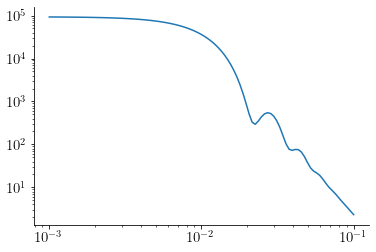

In [3]:
from sasmodels.core import load_model
from sasmodels.direct_model import call_kernel

model = load_model('sphere')
q = np.logspace(-3, -1, N_SAMPLES)
kernel = model.make_kernel([q])

def get_saxs(radius, pd):
    pars = {'radius': radius, "radius_pd": pd, "radius_pd_n": 100}
    Iq = call_kernel(kernel, pars)
    return Iq

fig, ax = plt.subplots()
Iqt = get_saxs(*TARGET)
ax.loglog(q, Iqt)
plt.show()

# set the functions to be log-log
yt = np.log10(Iqt)
xt = np.asarray(TARGET).reshape(1,2)

In [4]:
# define search space
param_r = [50,500]
param_pd = [1e-2,1]
bounds = torch.tensor((param_r, param_pd)).T.to(**tkwargs)

In [5]:
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.functions import L2Space, SinfSpace
H2 = PoincareHalfSpace(2)
Rn = Euclidean(N_SAMPLES)
R2 = Euclidean(len(TARGET))
L2 = L2Space(np.log10(q))
Sinf = SinfSpace(np.log10(q))

metric = 'L2'

if metric=='L2':
    d = lambda xi,yi : -L2.metric.dist(yi, yt)
elif metric=='Rn':
    d = lambda xi,yi : -float(Rn.metric.dist(yi, yt))
elif metric=='H2':
    xt = np.asarray(TARGET).reshape(1,2)
    d = lambda xi,yi : -float(H2.metric.dist(xi.reshape(1,2),xt))
elif metric=='R2':
    xt = np.asarray(TARGET).reshape(1,2)
    d = lambda xi,yi : -float(R2.metric.dist(xi.reshape(1,2),xt))  
elif metric=='Sinf':
    d = lambda xi,yi : -Sinf.metric.dist(yi, yt)
else:
    raise NotImplementedError('Metric %s is not implemented'%metric)

INFO: Using numpy backend


In [6]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()
    yi = np.log10(get_saxs(x_np[0],x_np[1]))
    dist = d(x_np, yi)
        
    expt[EXPT_ID] = [q, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [7]:
def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj

train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
if VERBOSE:
    print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
    for i in range(N_INIT_SAMPLES):
        print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 4 samples randomly torch.Size([4, 2]) torch.Size([4, 1])
0	[3.8955940e+02 1.6336761e-01]	[-0.59308967]
1	[343.1021452    0.54971554]	[-0.74661539]
2	[1.08182351e+02 1.51421326e-02]	[-0.69295903]
3	[462.63953745   0.69071682]	[-0.95034579]


In [8]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [9]:
def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [10]:
# run N_ITERATIONS rounds of BayesOpt after the initial random batch
if VERBOSE:
    print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1): 
    if VERBOSE:
        print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = best_f)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    if VERBOSE:
        for i in range(BATCH_SIZE):
            print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), 
                                new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[389.57609839   0.45047809]	[-0.76137201]
1	[190.82087334   0.73235824]	[-0.4880245]
2	[2.20146848e+02 2.08039758e-01]	[-0.19529361]
3	[68.00956712  0.74230003]	[-0.42007578]
Iteration : 2/10
0	[203.79748647   0.7938709 ]	[-0.5675156]
1	[76.91006996  0.41394073]	[-0.61059462]
2	[2.19972168e+02 1.72418816e-01]	[-0.16800894]
3	[260.81685047   0.4446607 ]	[-0.50791696]
Iteration : 3/10
0	[219.94921528   0.32286104]	[-0.28780444]
1	[3.70378863e+02 1.07519129e-01]	[-0.54521648]
2	[416.41151714   0.85497216]	[-0.96208461]
3	[399.41897453   0.84620914]	[-0.94365178]
Iteration : 4/10
0	[2.12721942e+02 1.09012399e-01]	[-0.08994891]
1	[348.22201529   0.40253956]	[-0.66686652]
2	[2.20057455e+02 4.17437648e-02]	[-0.20062937]
3	[67.40417955  0.72176499]	[-0.44407669]
Iteration : 5/10
0	[88.96746491  0.89202424]	[-0.14550973]
1	[197.90512197   0.79244376]	[-0.54756237]
2	[2.12492822e+02 7.11780058e-02]	[-0.09470584]
3	[189.80665175   0.81048371]

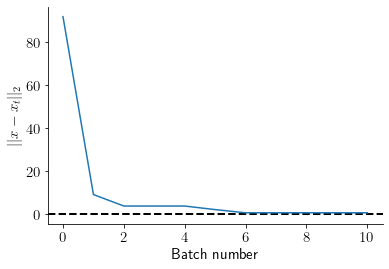

In [11]:
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

def plot_best_trace(ax, train_x, train_obj, target):
    train_x = train_x.cpu().numpy()
    proximities = distance.cdist(train_x, np.asarray(TARGET).reshape(1,2))
    trace = np.asarray([min(proximities[batch_number<=b]) for b in np.unique(batch_number)])
    return ax.plot(np.arange(N_ITERATIONS+1),trace)

fig, ax = plt.subplots()
ax.axhline(0, label='Optimal', ls='--', lw='2.0', c='k')
plot_best_trace(ax, train_x, train_obj, TARGET)
ax.set_xlabel('Batch number')
ax.set_ylabel(r'$||x-x_{t}||_{2}$')
plt.show()

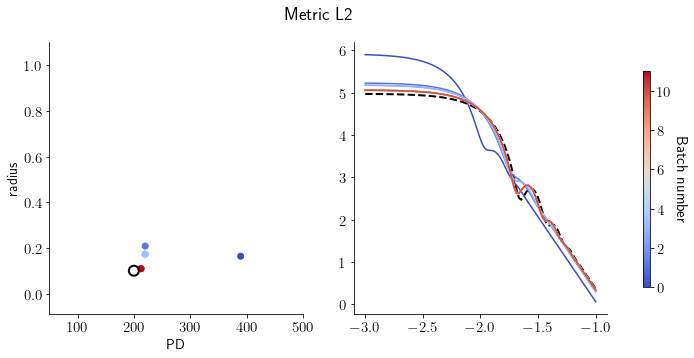

In [12]:
fig, axs = plt.subplots(1,2,figsize=(5*2,5))
batches = np.unique(batch_number)
best_ind = [np.argmax(train_obj.numpy()[batch_number<=b]) for b in batches]
best_loc = train_x[best_ind].numpy()
ax = axs[0]
ax.scatter(best_loc[:,0], best_loc[:,1], c=batches, cmap='coolwarm')
ax.set_xlim(bounds.numpy()[:,0] + np.asarray([-0.1,0.1]))
ax.set_ylim(bounds.numpy()[:,1] + np.asarray([-0.1,0.1]))
ax.scatter(TARGET[0], TARGET[1], marker='o', 
           s=100, facecolors='none', color='k', lw=2.0)
ax.set_xlabel('PD', fontsize=14)
ax.set_ylabel('radius', fontsize=14)

ax = axs[1]
ax.plot(np.log10(q), yt, 'k--', lw=2.0)
cmap = cm.get_cmap('coolwarm')
norm = matplotlib.colors.Normalize(vmin=0, vmax = len(batches))
for i, bind in enumerate(best_ind):
    q, logIq, _ = expt[bind]
    ax.plot(np.log10(q), logIq, color=cmap(norm(i)))
cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.set_ylabel('Batch number', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
fig.suptitle('Metric %s'%metric)
plt.show()

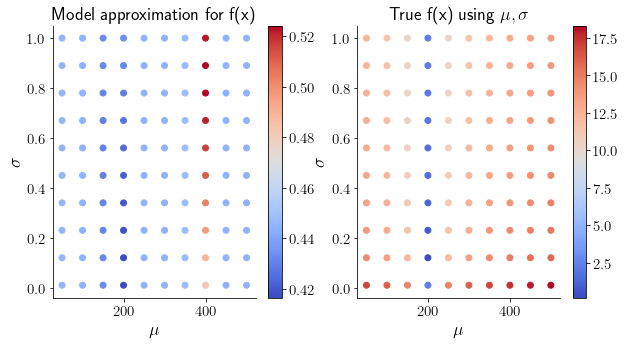

In [13]:
fig, axs = plt.subplots(1,2, figsize=(5*2, 5))
for ax in axs:
    ax.set_xlabel(r'$\mu$', fontsize=18)
    ax.set_ylabel(r'$\sigma$', fontsize=18)
with torch.no_grad():
    mu_grid = np.linspace(*bounds[:,0].numpy(), num=10)
    sig_grid = np.linspace(*bounds[:,1].numpy(), num=10)
    test_x = head.Grid(mu_grid, sig_grid).points
    posterior = model.posterior(torch.tensor(test_x).to(**tkwargs))
    sc = axs[0].scatter(test_x[:,0], test_x[:,1], 
                        c=-posterior.mean.cpu().numpy(), 
                        cmap='coolwarm')
    fig.colorbar(sc, ax=axs[0])
    axs[0].set_title('Model approximation for f(x)')
    
    #sc = axs[1].scatter(test_x[:,0], test_x[:,1], c=distance.cdist(test_x, np.asarray(TARGET).reshape(1,2)))
    sc = axs[1].scatter(test_x[:,0], test_x[:,1], 
                        c=H2.metric.dist(test_x, np.asarray(TARGET).reshape(1,2)),
                        cmap='coolwarm')
    fig.colorbar(sc, ax=axs[1])
    axs[1].set_title(r'True f(x) using $\mu, \sigma$')
plt.show()

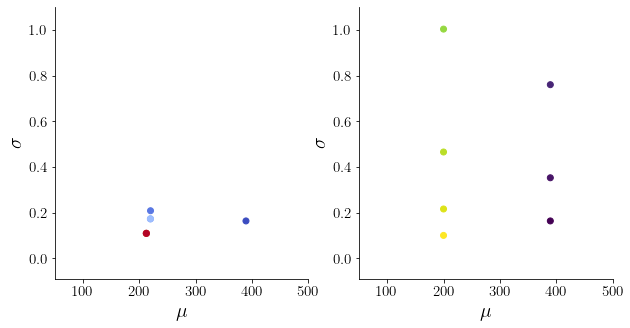

In [14]:
# plot trace in H2
from geomstats import visualization as viz

fig, axs = plt.subplots(1,2, figsize=(5*2, 5))

viz.plot(best_loc,c=batches,cmap='coolwarm', 
              space='H2_poincare_half_plane', ax=axs[0])

x0 = best_loc[0,:]
geodesic = H2.metric.geodesic(x0, xt)
n_points = 20
t = np.linspace(0, 1, n_points)
viz.plot(geodesic(t),c=t,space='H2_poincare_half_plane', ax= axs[1])

for ax in axs:
    ax.set_xlabel(r'$\mu$', fontsize=20)
    ax.set_ylabel(r'$\sigma$', fontsize=20)
    ax.set_xlim(bounds.numpy()[:,0] + np.asarray([-0.1,0.1]))
    ax.set_ylim(bounds.numpy()[:,1] + np.asarray([-0.1,0.1]))
plt.show()